# **Implementación del algoritmo para el proceso de entrenamiento, cuantización e inferencia (fuera de línea) y evaluación comparativa de la Red Neuronal Artificial Profunda (RNAP): Perceptrón Multicapa (MLP) en su variante original y cuantizada de tipo Rango Dinámico mediante TensorFlow, TensorFlow Lite y scikit-learn en Python**


------------------------------------------------------------
 Nombre del archivo  : step01_MultiLayerPerceptron_sEMGnomMinMaxForSubjectFFCLE.ipynb

 Autor               :   Jonathan Eduardo Castilla Zamora

 Github              :   https://github.com/JonathanCastilla/sEMG-RealTime-PatternRecognition-for-GripperControl

 Institución         :   Instituto Politécnico Nacional (IPN)

 Fecha de creación   :   Febrero/2025

 Última modificación :   Junio/2025

 Versión             :   1.3.1

 Descripción         :   Finalmente, dado por concluido el proceso de selección de características tiene como lugar la implementación del algoritmo asociado al clasificador. Bajo esta aseveración, se puede abordar que el propósito de cada una de las etapas desarrolladas previamente tienen como dirección la elaboración de un clasificador que corresponde al dominio de la Inteligencia Artificial, específicamente del subdominio del Aprendizaje Profundo (Deep Learning) dentro del Aprendizaje Automático (Machine Learning). Esto tras obtener los resultados del último procedimiento de la discriminación de características por parte de la conjunción de los algoritmos de Matriz de Correlación como del Analisis de Componentes Principales (PCA), que dan como resultado un conjunto de los vectores de características con menor grado de asociacion lineal entre ellas, de tal forma que estas variables elegidas explican la variabilidad del conjunto de las muestras almacenadas y procesadas de los dos protocolos de adquisición M3sec y M5sec para todos los sujetos del conjunto de datos acorde al procedimiento de recorrido de ventanas y porcentajes de solapamiento para la extracción de estas características (variables).

 El objetivo del presente algoritmo, como se precisó en todo el proceso de Reconocimiento de Patrones de las señales sEMG, a través del conjunto de características representativas que explican colectivamente la mayor variabilidad de la información de todos los sujetos, de ambos protocolos de adquisición (M3sec y M5sec), y de ambos canales analógicos (EDC y FDS); la clasificación de las muestras almacenadas asociados a los gestos de muñeca con el fin de traducir estos movimientos (WF, WE, HC y REP) en comandos para el control de movimiento de la pinza robótica.
                        


------------------------------------------------------------

## Importación de bibliotecas

In [ ]:
# Importa pandas, utilizado para cargar y manipular conjuntos de datos en forma tabular (DataFrames),
# especialmente útil para leer archivos CSV y organizar características y etiquetas.
import pandas as pd

# Importa numpy, biblioteca fundamental para operaciones matemáticas y manejo de arreglos,
# muy utilizada para preparar los datos de entrada y salida en redes neuronales.
import numpy as np

# Importa matplotlib.pyplot, útil para visualizar gráficas en 2D como curvas de entrenamiento/validación,
# pérdidas, precisión o resultados de clasificación.
import matplotlib.pyplot as plt

# Importa la herramienta Axes3D de mpl_toolkits, que permite crear representaciones gráficas tridimensionales.
# Útil para visualizar datos en 3D, como características proyectadas o salidas de modelos.
from mpl_toolkits.mplot3d import Axes3D

# Importa train_test_split desde scikit-learn para dividir los datos en subconjuntos de entrenamiento, validación y prueba.
# Esto permite evaluar el desempeño general del modelo.
from sklearn.model_selection import train_test_split

# Importa TensorFlow, una biblioteca de aprendizaje profundo ampliamente utilizada para definir y entrenar redes neuronales.
import tensorflow as tf

# Importa funciones de evaluación de desempeño como accuracy_score, confusion_matrix y classification_report desde scikit-learn,
# útiles para medir la precisión, matriz de confusión y métricas como precision, recall y F1-score.
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# (Redundante, ya importado anteriormente) Reimporta train_test_split — puede eliminarse para evitar duplicación.
from sklearn.model_selection import train_test_split

# Importa la API Sequential de Keras (incluida en TensorFlow), que permite construir modelos capa por capa de manera secuencial.
from tensorflow.keras.models import Sequential

# Importa capas utilizadas en redes neuronales:
# Dense para capas totalmente conectadas, Dropout para regularización,
# BatchNormalization para normalizar activaciones, Activation para funciones de activación.
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation

# Importa to_categorical, que convierte etiquetas numéricas en codificación one-hot,
# esencial para clasificación multiclase.
from tensorflow.keras.utils import to_categorical

# Importa callbacks de Keras:
# EarlyStopping detiene el entrenamiento cuando no hay mejoras,
# ReduceLROnPlateau reduce la tasa de aprendizaje si la métrica de validación se estanca.
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# (Redundante) Reimporta Dropout — puede eliminarse si ya se importó previamente con `from tensorflow.keras.layers`.
from tensorflow.keras.layers import Dropout

# Importa el regularizador L2, que penaliza pesos grandes en las neuronas para evitar sobreajuste (overfitting).
from tensorflow.keras.regularizers import l2

# Importa MinMaxScaler desde scikit-learn para normalizar los datos de entrada al rango [0, 1],
# lo cual mejora la estabilidad y la convergencia del entrenamiento de redes neuronales.
from sklearn.preprocessing import MinMaxScaler

# Importa el optimizador Adam, un algoritmo de optimización eficiente basado en el descenso de gradiente,
# que adapta las tasas de aprendizaje durante el entrenamiento para acelerar la convergencia.
from tensorflow.keras.optimizers import Adam


## Definición de los archivos de datos correspondientes a cada gesto de muñeca para cada canal analógico:


* Extensor Común de los Dedos (EDC)

* Flexor Superficial de los Dedos (FDS)



### Características seleccionadas a partir de la matriz de Correlación y el Análisis de Componentes Principales (PCA)

### Protocolo de adquisición: M5sec

In [ ]:
# Definición de los archivos de datos correspondientes a cada gesto para ambos músculos (EDC y FDS)
# Archivos de datos M5sec
archivoWF_EDC_M5 = '/content/datosSensor_MAD_EDC_WF_M5sec_sEMG_nomMinMaxForSubject_FFC_LE_ESP32_IEMG-WL-MWL-Variance-DASDV_gestos_dataSet.csv' # Movimiento Wrist Flexion (WF) - Músculo EDC
archivoWF_FDS_M5 = '/content/datosSensor_MAD_FDS_WF_M5sec_sEMG_nomMinMaxForSubject_FFC_LE_ESP32_IEMG-WL-MWL-Variance-DASDV_gestos_dataSet.csv' # Movimiento Wrist Flexion (WF) - Músculo FDS
archivoWE_EDC_M5 = '/content/datosSensor_MAD_EDC_WE_M5sec_sEMG_nomMinMaxForSubject_FFC_LE_ESP32_IEMG-WL-MWL-Variance-DASDV_gestos_dataSet.csv' # Movimiento Wrist Extension (WE) - Músculo EDC
archivoWE_FDS_M5 = '/content/datosSensor_MAD_FDS_WE_M5sec_sEMG_nomMinMaxForSubject_FFC_LE_ESP32_IEMG-WL-MWL-Variance-DASDV_gestos_dataSet.csv' # Movimiento Wrist Extension (WE) - Músculo FDS
archivoHC_EDC_M5 = '/content/datosSensor_MAD_EDC_HC_M5sec_sEMG_nomMinMaxForSubject_FFC_LE_ESP32_IEMG-WL-MWL-Variance-DASDV_gestos_dataSet.csv' # Movimiento Hand Close (HC) - Músculo EDC
archivoHC_FDS_M5 = '/content/datosSensor_MAD_FDS_HC_M5sec_sEMG_nomMinMaxForSubject_FFC_LE_ESP32_IEMG-WL-MWL-Variance-DASDV_gestos_dataSet.csv' # Movimiento Hand Close (HC) - Músculo FDS

### Protocolo de adquisición: M3sec

In [ ]:
# Archivos de datos M3sec
archivoWF_EDC_M3 = '/content/datosSensor_MAD_EDC_WF_M3sec_sEMG_nomMinMaxForSubject_FFC_LE_ESP32_IEMG-WL-MWL-Variance-DASDV_gestos_dataSet.csv' # Movimiento Wrist Flexion (WF) - Músculo EDC
archivoWF_FDS_M3 = '/content/datosSensor_MAD_FDS_WF_M3sec_sEMG_nomMinMaxForSubject_FFC_LE_ESP32_IEMG-WL-MWL-Variance-DASDV_gestos_dataSet.csv' # Movimiento Wrist Flexion (WF) - Músculo FDS
archivoWE_EDC_M3 = '/content/datosSensor_MAD_EDC_WE_M3sec_sEMG_nomMinMaxForSubject_FFC_LE_ESP32_IEMG-WL-MWL-Variance-DASDV_gestos_dataSet.csv' # Movimiento Wrist Extension (WE) - Músculo EDC
archivoWE_FDS_M3 = '/content/datosSensor_MAD_FDS_WE_M3sec_sEMG_nomMinMaxForSubject_FFC_LE_ESP32_IEMG-WL-MWL-Variance-DASDV_gestos_dataSet.csv' # Movimiento Wrist Extension (WE) - Músculo FDS
archivoHC_EDC_M3 = '/content/datosSensor_MAD_EDC_HC_M3sec_sEMG_nomMinMaxForSubject_FFC_LE_ESP32_IEMG-WL-MWL-Variance-DASDV_gestos_dataSet.csv' # Movimiento Hand Close (HC) - Músculo EDC
archivoHC_FDS_M3 = '/content/datosSensor_MAD_FDS_HC_M3sec_sEMG_nomMinMaxForSubject_FFC_LE_ESP32_IEMG-WL-MWL-Variance-DASDV_gestos_dataSet.csv' # Movimiento Hand Close (HC) - Músculo FDS

### Archivos CSV unificados de características para ambos canales analógicos (EDC y FDS)

In [ ]:
# Archivos de reposo
archivoREP_EDC = '/content/reposo_EDC_unificado_dataSet.csv'
archivoREP_FDS = '/content/reposo_FDS_unificado_dataSet.csv'

## Normalización de vectores de características de las matrices resultantes del proceso de Extracción de Características mediante propuesta de recorridos de ventana y porcentajes de solapamiento

### Declaración de función para Normalización tipo MinMax

In [ ]:
# Función para normalizar cada columna de una matriz de manera independiente
def normalize_columns(matrix):
    # If the input is a DataFrame, convert it to a NumPy array
    if isinstance(matrix, pd.DataFrame):
        matrix = matrix.to_numpy()

    # Crear una copia de la matriz para no modificar la original
    normalized_matrix = np.zeros_like(matrix, dtype=float)

    # Recorrer cada columna y normalizarla
    for col in range(matrix.shape[1]):
        scaler = MinMaxScaler()
        normalized_matrix[:, col] = scaler.fit_transform(matrix[:, col].reshape(-1, 1)).flatten()

    return normalized_matrix

##  Carga y preparación de los conjuntos de características exportados en archivos CSV por tipo de gesto de muñeca (WF, WE, HC y REP), por músculo (canal analógico) (FDS y EDC) y por protocolo de adquisición (M3sec y M5sec).

1. Nuevamente, el algoritmo hereda la importación del conjunto de características relevantes resultantes del Análisis de Componentes Principales (PCA) mediante la definición de las rutas de acceso a los archivos CSV a cada uno de los documentos que contienen las características extraídas para cada gesto. De manera análoga, se cargan los datos correspondientes al gesto de reposo que presentan la peculiaridad de que el conjunto de datos se encuentra unificado por la naturaleza del gesto al que remite (REP: reposo).

  En particular, se retoma la consideración de la caracterización de los gestos de muñeca que aluden a tres acciones motoras voluntarias (Flexión de muñeca, Extensión de muñeca y Mano cerrada, abreviadas como WF, WE, y HC, respectivamente), así como una condición de reposo (REP), dónde estas señales fueron registradas simultáneamente desde dos músculos de la zona del antebrazo: Extensor Común de los dedos (EDC) y Flexor Superficial de los dedos (FDS), de tal modo que cada gesto fue almacenado en archivos separados según el músculo y la duración del segmento de adquisición: 3 segundos (M3sec) y 5 segundos (M5sec) asociado al periodo de tiempo realización sostenido (prolongado) del gesto sostenido. Estos archivos son cargados como objetos DataFrame de pandas y concatenados verticalmente para formar un único conjunto unificado por gesto y músculo.

2. Tras la carga de datos de las características (variables) representativas resultantes del algoritmo del Análisis de Componentes Principales (PCA), se elimina nuevamente la primera columna, que corresponde al índice o número de muestra (número de ventana de recorrido) conservando únicamente las columnas con las características extraídas del Análisis de Componentes Principales (PCA) dado que, como el caso de los algoritmos explicados con anterioridad, no aporta información de interés para la implementación del clasificador de Aprendizaje de tipo supervisado ni del subdominio del Aprendizaje Profundo (Deep Learning): Perceptrón Multicapa (MLP). De igual forma, el conjunto de datos se convierten en matrices NumPy para facilitar su manipulación posterior.

3. Las matrices resultantes son convertidas a estructuras de tipo numpy.ndarray para facilitar operaciones matemáticas subsecuentes. Luego, todas las matrices son recortadas de manera uniforme hasta el mínimo número de filas (valores de las ventanas de características extraídas) entre todas ellas, garantizando que cada clase tenga igual número de muestras y evitar sesgos de entrenamiento, como lo implementado en algoritmos anteriores. Este enfoque permite asegurar que cada clase contenga el mismo número de ejemplos. Tras finalizar esto, se concatenan verticalmente las muestras para formar dos matrices completas: una para el músculo Extensor Digitorum Communis (EDC) y otra para el Flexor Digitorum Superficialis (FDS).

In [ ]:
# Cargar archivos en DataFrames
WF_EDC = pd.concat([
    pd.read_csv(archivoWF_EDC_M5),
    pd.read_csv(archivoWF_EDC_M3)
], ignore_index=True)

WF_FDS = pd.concat([
    pd.read_csv(archivoWF_FDS_M5),
    pd.read_csv(archivoWF_FDS_M3)
], ignore_index=True)

WE_EDC = pd.concat([
    pd.read_csv(archivoWE_EDC_M5),
    pd.read_csv(archivoWE_EDC_M3)
], ignore_index=True)

WE_FDS = pd.concat([
    pd.read_csv(archivoWE_FDS_M5),
    pd.read_csv(archivoWE_FDS_M3)
], ignore_index=True)

HC_EDC = pd.concat([
    pd.read_csv(archivoHC_EDC_M5),
    pd.read_csv(archivoHC_EDC_M3)
], ignore_index=True)

HC_FDS = pd.concat([
    pd.read_csv(archivoHC_FDS_M5),
    pd.read_csv(archivoHC_FDS_M3)
], ignore_index=True)

# Reposo se mantiene igual
REP_EDC = pd.read_csv(archivoREP_EDC)
REP_FDS = pd.read_csv(archivoREP_FDS)

# Extraer características
caracteristicas = WF_EDC.columns[1:].tolist()
print("Características:", caracteristicas)

# Eliminar primera columna (número de muestra)
WF_EDC = WF_EDC.iloc[:, 1:]
WF_FDS = WF_FDS.iloc[:, 1:]
WE_EDC = WE_EDC.iloc[:, 1:]
WE_FDS = WE_FDS.iloc[:, 1:]
HC_EDC = HC_EDC.iloc[:, 1:]
HC_FDS = HC_FDS.iloc[:, 1:]
REP_EDC = REP_EDC.iloc[:, 1:]
REP_FDS = REP_FDS.iloc[:, 1:]

# Convertir a matrices NumPy
matrices_EDC = [WF_EDC.to_numpy(), WE_EDC.to_numpy(), HC_EDC.to_numpy(), REP_EDC.to_numpy()]
matrices_FDS = [WF_FDS.to_numpy(), WE_FDS.to_numpy(), HC_FDS.to_numpy(), REP_FDS.to_numpy()]

# Determinar mínimo de filas
min_filas = min(mat.shape[0] for mat in matrices_EDC + matrices_FDS)

# Recortar todas al mínimo
matrices_EDC = [mat[:min_filas, :] for mat in matrices_EDC]
matrices_FDS = [mat[:min_filas, :] for mat in matrices_FDS]

# Concatenar verticalmente
P_EDC = np.vstack(matrices_EDC)
P_FDS = np.vstack(matrices_FDS)

print(f"P_EDC:  {P_EDC.shape}")
print(f"P_FDS:  {P_FDS.shape}")


## Unificación global y normalización de tipo MinMaxScaler por característica de las matrices de características para ambos canales analógicos: Extensor Digitorum Communis (EDC) y Flexor Digitorum Superficialis (FDS).

1. Las matrices de características asociadas a ambos canales analógicos (FDS y EDC) se concatenan en una sola matriz, este es la última unificación de los conjuntos de datos, representando la fusión de información de los valores de las ventanas de recorrido resultantes del proceso de extracción de características así como del primer proceso de discriminación de características debidamente ordenadas por característica de las señales sEMG multicanal.

    * Concatenación horizontal por cada conjunto de características por músculo (EDC y FDS) para distinción de aporte de características (ventanas de extracción) por canal analógico: Particularmente, las matrices correspondientes al músculo EDC y FDS que se concatenaron verticalmente para formar dos matrices globales por músculo: PEDC y PFDS, respectivamente, se concatenan horizontalmente de manera global mediante np.hstack() para formar la matriz global de características P, la cual combina toda la información extraída de ambos músculos, dónde se consideran el aporte de características por cada uno. Este hecho es fundamental dado que, si bien, hay una concatenación que consolida una matriz global de características, dada la forma de concatenación horizontal por cada conjunto de características por músculo (EDC y FDS) implica que el aporte de información de características viene dado por cada canal analógico, siendo de este modo que, si existen, verbigracia, 3 características relevantes del resultado del Análisis de Componentes Principales (PCA), resultarán en un total de 6 características de entrada para el clasificador, un número de 3 características por actividad mioeléctrica por músculo.
      * El propósito de esta concatenación, a diferencia del proceso de selección de características tiene como fin entrenar el clasificador de tal manera que pueda realizar las inferencia de los gestos de la muñeca dada la aportación de ambos canales analógicos (Extensor Común de los Dedos y Flexor Superficial de los Dedos) a través de las características relevantes, iguales para cada canal.

2. Minimizar (y converger) la función de coste en el entrenamiento de la
 Red Neuronal Profunda (RNAP) mediante normalización por cada vec
tor de características:

    * Posteriormente, la matriz global de características (ventanas de recorrido) P es normalizada mediante una función auxiliar *normalizecolumns* aplicada para los algoritmos de selección de características, que aplica la normalización de tipo Min-Max-Scaler individualmente a cada columna (característica), escalando los valores de cada vector de características al rango R : [0,1]. Esta normalización, a diferencia de asegurar para el proceso de selección de características que permite facilitar la identificación de la correlación entre características y las variables representativas de la combinación lineal de las componentes principales en  el PCA; permite garantizar la equidad de escala entre las distintas características, otorgando estabilidad numérica en modelos de aprendizaje automático, precisamente, para el entrenamiento del Perceptrón Multicapa (MLP) soslaya que una variable (característica de entrada) predomine sobre otra, garantizando que las sumas ponderadas, tanto resultados de las funciones de agregación como de activación, y el ajuste de los pesos dentro del proceso de Forward Propagation como de Backward Propagation permitan reducir la función de coste en el entrenamiento de la Red Neuronal Profunda (RNAP).

3.  Se vuelve a remarcar de que, pese a que la extracción de características procede a muestras ya normalizadas de tipo MinMaxScaler por sujeto (específicamente, del tipo de postprocesamiento Feed Forward Comb (FFC) con Envolvente Lineal obtenido desde el microcontrolador ESP32), esto no garantiza dada la naturaleza de las diferentes características al calcularse que los valores de las ventanas de recorrido extraídas estén acotados en el rango R : [0,1]. Esta aseveración se comprobó en los resultados obtenidos de los algoritmos asociados al proceso de selección de características.

## Etiquetado y división del conjunto de datos en conjuntos de Entrenamiento,Validación y Prueba para el entrenamiento como inferencia (fuera de línea) del Perceptrón Multicapa (MLP) mediante scikit-learn y Tensorflow

In [ ]:

# Concatenación de características de ambos músculos
P = np.hstack((P_EDC, P_FDS))
print(f"Concatenación de datos: {P.shape}")

# Normalización MinMax Scaler para el conjunto de datos P
P = normalize_columns(P)

# Creación de etiquetas para la clasificación (0: WF, 1: WE, 2: HC, 3: REP)
y = np.concatenate([
    np.zeros(min_filas),  # WF
    np.ones(min_filas),   # WE
    np.full(min_filas, 2), # HC
    np.full(min_filas, 3)  # REP
])

# División de los datos en entrenamiento (80%), validación (10%) y prueba (10%)
# División de los datos por canal analógico (músculo) para visualización de su conteo
X_train_EDC, X_temp_EDC, y_train, y_temp = train_test_split(P_EDC, y, test_size=0.2, random_state=42)
X_train_FDS, X_temp_FDS, _, _ = train_test_split(P_FDS, y, test_size=0.2, random_state=42)

X_val_EDC, X_test_EDC, y_val, y_test = train_test_split(X_temp_EDC, y_temp, test_size=0.5, random_state=42)
X_val_FDS, X_test_FDS, _, _ = train_test_split(X_temp_FDS, y_temp, test_size=0.5, random_state=42)

# División en entrenamiento (80%) y el 20% restante para validación y prueba
X_train, X_temp, y_train, y_temp = train_test_split(P, y, test_size=0.2, stratify=y, random_state=42)

# División del 20% restante en validación (10%) y prueba (10%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Conversión de etiquetas a formato One-Hot Encoding
y_train = to_categorical(y_train, num_classes=4)
y_val = to_categorical(y_val, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)

# Verificación de tamaños
print(f"Forma de los conjuntos de datos individuales:")
print(f"Entrenamiento: X_train_EDC {X_train_EDC.shape}, X_train_FDS {X_train_FDS.shape}, y_train {y_train.shape}")
print(f"Validación: X_val_EDC {X_val_EDC.shape}, X_val_FDS {X_val_FDS.shape}, y_val {y_val.shape}")
print(f"Prueba: X_test_EDC {X_test_EDC.shape}, X_test_FDS {X_test_FDS.shape}, y_test {y_test.shape}")

print(f"\nForma de los conjuntos de datos totales:")
print(f"Entrenamiento: X_train {X_train.shape}, y_train {y_train.shape}")
print(f"Validación: X_val {X_val.shape}, y_val {y_val.shape}")
print(f"Prueba: X_test {X_test.shape}, y_test {y_test.shape}")

Características: ['IEMG', 'WL', 'MWL', 'Variance', 'DASDV']
P_EDC:  (26360, 5)
P_FDS:  (26360, 5)
Concatenación de datos: (26360, 10)
Forma de los conjuntos de datos individuales:
Entrenamiento: X_train_EDC (21088, 5), X_train_FDS (21088, 5), y_train (21088, 4)
Validación: X_val_EDC (2636, 5), X_val_FDS (2636, 5), y_val (2636, 4)
Prueba: X_test_EDC (2636, 5), X_test_FDS (2636, 5), y_test (2636, 4)

Forma de los conjuntos de datos totales:
Entrenamiento: X_train (21088, 10), y_train (21088, 4)
Validación: X_val (2636, 10), y_val (2636, 4)
Prueba: X_test (2636, 10), y_test (2636, 4)


## Visualización del espacio de características por cada canal analógico (EDC y FDS) y comprobación de distribución uniforme de datos por clase (gesto de muñeca): Análisis del comportamiento de cada gesto de muñeca por su extracción de características en cada músculo.

Se procede a verificar la distribución uniforme de muestras por cada una de las 4 clases como acción a posteriori de la división, dónde se prescinde de varios gráficos asociados a histogramas de frecuencias para cada estrato de división (entrenamiento, validación, prueba), permitiendo comprobar la uniformidad de la distribución de clases

In [ ]:
# Antes del split (debería mostrar orden perfecto)
print("Primeras etiquetas ANTES de mezclar:", y[:20])

# Después del split (debería mostrar mezcla)
print("\nDistribución en Train:")
unique, counts = np.unique(np.argmax(y_train, axis=1), return_counts=True)
print(dict(zip(unique, counts)))

print("\nEjemplo de primeras etiquetas en Train:")
print(np.argmax(y_train[:20], axis=1))  # Debería mostrar clases mezcladas

Primeras etiquetas ANTES de mezclar: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

Distribución en Train:
{np.int64(0): np.int64(5272), np.int64(1): np.int64(5272), np.int64(2): np.int64(5272), np.int64(3): np.int64(5272)}

Ejemplo de primeras etiquetas en Train:
[3 2 3 2 0 3 3 2 2 2 0 0 3 0 1 2 2 1 0 3]


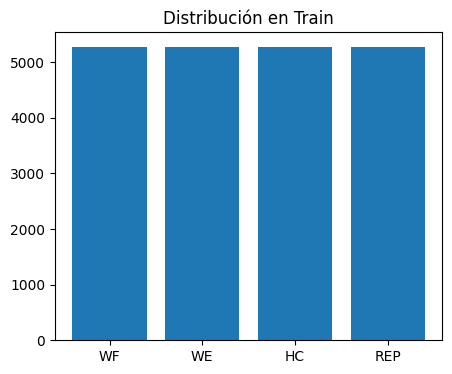

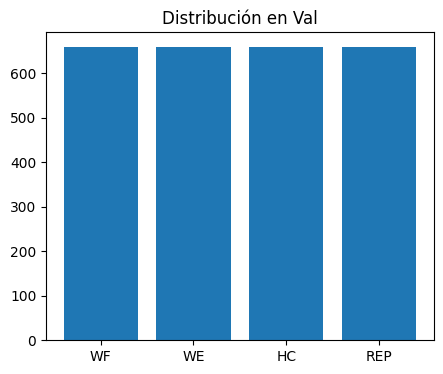

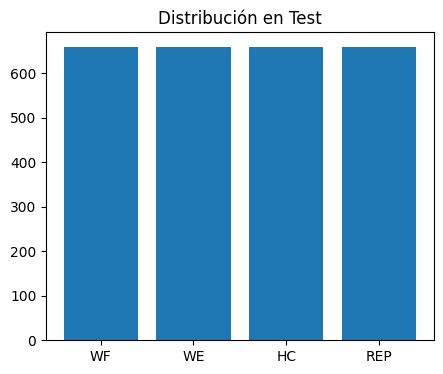

In [ ]:
def plot_class_distribution(y, title):
    classes, counts = np.unique(np.argmax(y, axis=1), return_counts=True)
    plt.figure(figsize=(5, 4))
    plt.bar(['WF', 'WE', 'HC', 'REP'], counts)
    plt.title(title)
    plt.show()

plot_class_distribution(y_train, "Distribución en Train")
plot_class_distribution(y_val, "Distribución en Val")
plot_class_distribution(y_test, "Distribución en Test")

### Representación tridimensional del espacio de características por cada canal analógico

 Representación tridimensional del espacio de características por cada canal analógico, evidentemente, esta visualización se encuentra delimitada a un número de tres características de entrada por canal analógico para el Perceptrón Multicapa (MLP). Empero; permite comprobar de manera visual la distinción del comportamiento de las ventanas de recorrido en cada músculo dependiendo del tipo de gesto de muñeca del que provienen. En este sentido, se emplearon gráficos de dispersión en 3D, desembocando así, en una visualización intuitiva del grado de separabilidad entre clases (gestos) y la estructura general del espacio de características.

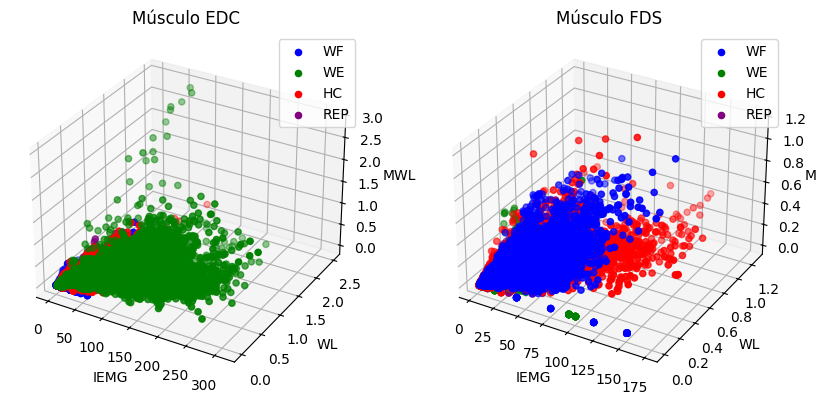

In [ ]:
# Determinación del tamaño del número de muestras por cada canal analógico (músculo del antebrazo)
num_muestras_WF = WF_EDC.shape[0]
num_muestras_WE = WE_EDC.shape[0]
num_muestras_HC = HC_EDC.shape[0]
num_muestras_REP = REP_EDC.shape[0]  # Nuevo: Muestras de REP

# Definición de los índices (límites) para ajustar el tamaño de la gráfica para visualización de características
limite_WF = num_muestras_WF
limite_WE = limite_WF + num_muestras_WE
limite_HC = limite_WE + num_muestras_HC
limite_REP = limite_HC + num_muestras_REP  # Nuevo: Límite para REP

# Creación de la figura para la representación tridimensional de ambos músculos
fig = plt.figure(figsize=(10, 8))

# Subgráfico para el músculo EDC
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(P_EDC[:limite_WF, 0], P_EDC[:limite_WF, 1], P_EDC[:limite_WF, 2], c='blue', marker='o', label='WF')
ax1.scatter(P_EDC[limite_WF:limite_WE, 0], P_EDC[limite_WF:limite_WE, 1], P_EDC[limite_WF:limite_WE, 2], c='green', marker='o', label='WE')
ax1.scatter(P_EDC[limite_WE:limite_HC, 0], P_EDC[limite_WE:limite_HC, 1], P_EDC[limite_WE:limite_HC, 2], c='red', marker='o', label='HC')
ax1.scatter(P_EDC[limite_HC:limite_REP, 0], P_EDC[limite_HC:limite_REP, 1], P_EDC[limite_HC:limite_REP, 2], c='purple', marker='o', label='REP')  # Nuevo: REP
ax1.set_xlabel(caracteristicas[0])
ax1.set_ylabel(caracteristicas[1])
ax1.set_zlabel(caracteristicas[2])
ax1.set_title('Músculo EDC')
ax1.legend()

# Subgráfico para el músculo FDS
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(P_FDS[:limite_WF, 0], P_FDS[:limite_WF, 1], P_FDS[:limite_WF, 2], c='blue', marker='o', label='WF')
ax2.scatter(P_FDS[limite_WF:limite_WE, 0], P_FDS[limite_WF:limite_WE, 1], P_FDS[limite_WF:limite_WE, 2], c='green', marker='o', label='WE')
ax2.scatter(P_FDS[limite_WE:limite_HC, 0], P_FDS[limite_WE:limite_HC, 1], P_FDS[limite_WE:limite_HC, 2], c='red', marker='o', label='HC')
ax2.scatter(P_FDS[limite_HC:limite_REP, 0], P_FDS[limite_HC:limite_REP, 1], P_FDS[limite_HC:limite_REP, 2], c='purple', marker='o', label='REP')  # Nuevo: REP
ax2.set_xlabel(caracteristicas[0])
ax2.set_ylabel(caracteristicas[1])
ax2.set_zlabel(caracteristicas[2])
ax2.set_title('Músculo FDS')
ax2.legend()

# Mostrar la gráfica
plt.show()

## Manejo de Valores Faltantes

Se realiza la verificación asociada a la imputación de datos no definidos (valores NaN), esto para corregir posibles errores en el cálculo de características de algoritmos previos en caso de presentarse. Este reemplazo de valores no definidos (NaN) se implementó, de igual forma, mediante propagación hacia adelante (forward fill) y propagación hacia atrás (backward fill) que permite sustituir estos valores no definidas para una ventana en particular con el valor de una ventana previa o posterior, como se abordó y se detalló para el caso de la Matriz de Correlación.

In [ ]:
print(np.isnan(X_train).sum(), np.isnan(y_train).sum(), np.isnan(X_val).sum(), np.isnan(y_val).sum(), np.isnan(X_test).sum(), np.isnan(y_test).sum())
print(np.isinf(X_train).sum(), np.isinf(y_train).sum(), np.isinf(X_val).sum(), np.isinf(y_val).sum(), np.isinf(X_test).sum(), np.isinf(y_test).sum())

0 0 0 0 0 0
0 0 0 0 0 0


In [ ]:
# Reemplazar NaN con 0 (o con la media de la columna si prefieres)
X_train = np.nan_to_num(X_train, nan=0.0)
X_test = np.nan_to_num(X_test, nan=0.0)
Y_train = np.nan_to_num(y_train, nan=0.0)
Y_test = np.nan_to_num(y_test, nan=0.0)
X_val = np.nan_to_num(X_val, nan=0.0)
Y_val = np.nan_to_num(y_val, nan=0.0)

In [ ]:
print("Min:", X_train.min(), "Max:", X_train.max())
print("Min:", X_test.min(), "Max:", X_test.max())
print("Min:", X_val.min(), "Max:", X_val.max())
print("Min:", y_train.min(), "Max:", y_train.max())
print("Min:", y_test.min(), "Max:", y_test.max())
print("Min:", y_val.min(), "Max:", y_val.max())

Min: 0.0 Max: 1.0
Min: 0.0 Max: 0.9741581966635117
Min: 0.0 Max: 1.0
Min: 0.0 Max: 1.0
Min: 0.0 Max: 1.0
Min: 0.0 Max: 1.0


##  Diseño y arquitectura de la Red Neuronal Profunda (RNAP): Perceptrón Multicapa (MLP)

1. **Arquitectura de la Red Neuronal Profunda (RNAP)**:
  * **Primera capa densa (Dense Layer 1)**:

    En esta primera capa funge la entrada un vector de características de di mensión input_dim = 10. Dados los resultados del algoritmo Análisis de Componentes Principales (PCA) que se detallará más adelante en la sección de Resultados. En este sentido, las 10 características se dividen en 5 para el músculo Extensor Común de los Dedos (EDC) y 5 para el músculo Flexor Superficial de los Dedos (FDS), como detalló en la secciones anteriores, al concatenarse las características de forma horizontal para la matriz de características resultantes se considera el aporte de estas características por cada canal analógico.

 * Por otra parte, se da lugar a la inicialización He (He Normal Initialization), cuál es recomendada para funciones de activación de tipo ReLU dado que permite mantener la varianza estable entre cada una de las capas profundas además de ayudar a la convergencia del entrenamiento del Perceptrón
 Multicapa (MLP)

2. **Función de activación de tipo ReLU (Rectified Linear Unit)**:

  * Para el caso de la función de activación, se decidió por utilizar la función de tipo ReLU( f(x) = max(0,x)), que permite eludir el problema del desvanecimiento del gradiente.

3. **Dropout**:
  * Por otra parte, se emplea una técnica nombrada como dropout, cuál consiste que, a posteriori, de cada capa oculta se desactivan de manera aleatorio un porcentaje de neuronas del número total de estas durante el proceso de entrenamiento, permitiendo así, ofrecer lo que se denomina una regularización permitiendo prevenir el sobreajuste del modelo que entorpece la minimización de pérdida para la validación.

  * Por otra parte, es posible mencionar que el coeficiente de dropout elegido bastó de un 5%, esto tras hacer varia iteraciones del algoritmo, resultó en el valor que presentó mejor calidad de predicción en el conjunto de prueba evitando el sobreajuste identificado durante pruebas en el entrenamiento sin utilizar esta técnica. Bajo este respecto, es posible mencionar como posible justificación del valor bajo del dropout en la medida que se implementó un número bajo de neuronas por cada capa oculta, como se verá a continuación; con el fin de reducir tiempos de inferencia en línea, así como el añadido de aplicación de normalización aportando regularización adicional.

3. **Capas ocultas**:
  * Posteriormente, se agregaron dos capas densas adicionales con 128, 64 y 32 neuronas respectivamente, manteniendo las funciones de activación de tipo ReLU así el mismo valor de tasa para el coeficiente de dropout.

4. **Capa de Salida (Output Layer)**:
  * Finalmente, la capa de salida consta de un número de 4 neuronas correspondientes precisamente al número de comandos de muñeca a predicir para el sistema de inferencia, es decir, a las clases WF, WE, HC y REP, cuáles fueron codificadas en formato one-hot.

  * Cabe ser mencionado que, para el caso de la función de activación para
  esta última capa se aplicó la función de activación de tipo softmax que,
  como es posible encontrar en la literatura, es la más común de emplear
  dado que transforma la salida en una distribución de probabilidad sobre
  estas clases, permitiendo así la interpretación de la salida en tareas de
  clasificación multiclase así como de poder, a través de obtener un valor de
  probabilidad para cada clase, utilizar un enfoque de votación ponderada en
  conjunto con otro clasificador para el sistema de inferencia, enfoque que se
  detallará más adelante.

5. **Compilación**:
  * Bajo este respecto, se hizo uso del optimizador nombrado Adam (Adaptive Moment Estimation), el cuál permite obtener los beneficios de RMSProp y Momentum, generando una convergencia más rápida y estable en Redes Neuronales Profudas (RNAP), en este caso, para la implementación del Perceptrón Multicapa (MLP)

  * La función de coste utilizada fue categorical_crossentropy, la cuál es común y adecuada la resolución de problemas de clasificación de tipo multiclase donde las etiquetas se encuentran codificadas en formato one-hot.

In [ ]:
# Función para crear modelos MLP
def createMultiLayerPerceptronModel(input_dim, neurons_HL1, neurons_HL2, neurons_HL3, output_dim, coefficient_dropout):
    model = Sequential()
    model.add(Dense(neurons_HL1, input_dim=input_dim, activation='relu'))
    model.add(Dropout(coefficient_dropout))  # % de dropout
    model.add(Dense(neurons_HL2, activation='relu'))
    model.add(Dropout(coefficient_dropout))  # % de dropout
    model.add(Dense(neurons_HL3, activation='relu'))
    model.add(Dropout(coefficient_dropout))  # % de dropout
    model.add(Dense(output_dim, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

## Entrenamiento del modelo con la arquitectura de la Red Neuronal Artificial Profunda (RNAP) propuesta.

1. Verificación de existencia de valores no defindos NaNs en el subconjunto de entrenamiento como de validación
  * Previo al iniciar el proceso de entrenamiento, se verifica la presencia de valores indefinidos (NaN) en los datos. Esta verificación se realiza en la medida que la existencia de estos en el subconjunto de datos de entrenamiento puede interferir para el proceso de Forward Propagation impidiendo la convergencia del modelo.

2. Implementación de Early Stopping
  * Por otro lado, de símil modo, se implementó un mecanismo de detención temprana nombrado como *EarlyStopping* que permite analizar la pérdida de validación. En este sentido, lo que evalúa es que, dada la inexistencia de mejora en la curva de pérdida en validación después de 20 épocas consecutivas detiene el entrenamiento, devolviendo los mejores pesos entrenados durante el proceso, evitando el sobreajuste.

3. Evaluación del Perceptrón Multicapa (MLP) y visualización de métricas
 resultantes del proceso de entrenamiento
  *  Subsecuentemente, tras finalizar el proceso de entrenamiento, se evalúa el modelo entrenado mediante el subconjunto de prueba visualizando las siguientes
 métricas de entrenamiento:
    * Pérdida (Loss): Error promedio entre las predicciones realizadas por el clasificador y etiquetas verdaderas.
    * Precisión (Accuracy): Porcentaje de clasificaciones correctas por parte del clasificador.
  * Finalmente, se grafican las curvas asociadas a la pérdida como precisión para los procesos de entrenamiento como validación con el objetivo de identificar la existencia de sobreajuste o subajuste.

4. Inferencia del clasificador con el subconjunto de prueba (fuera de línea) y
 visualización de matriz de confusión.
  * Predicción del subconjunto de prueba
    * En este sentido, se utiliza model.predict() y np.argmax() para convertir las probabilidades de salida en etiquetas predichas.
  * Métricas resultantes de proceso de inferencia fuera de línea
    * accuracy_score: Precisión global.
    * confusion_matrix: Representación detallada de verdaderos positivos como de falsos negativos por clase (gesto de muñeca) predicho por la Red Neuronal Artificial Profunda (RNAP).
    * classification_report: Incluye precisión, exhaustividad (recall) y F1-score por clase.

In [ ]:
def trainingModel(model, epochs, batch_size, X_train, y_train, X_val, y_val):
    # Verificar si hay NaN antes de entrenar
    def check_nan(X, y):
        if np.isnan(X).sum() > 0 or np.isnan(y).sum() > 0:
            raise ValueError("⚠️ ERROR: Hay NaN en los datos. Corrige esto antes de entrenar.")

    check_nan(X_train, y_train)
    check_nan(X_val, y_val)

    # Early stopping para evitar sobreajuste
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

    # Entrenamiento con callbacks
    history = model.fit(X_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_val, y_val),
                        callbacks=[early_stopping])

    return history


In [ ]:
def trainingModel(model, epochs, batch_size, X_train, y_train, X_val, y_val, verbose=1):
    # Verificar si hay NaN antes de entrenar
    def check_nan(X, y):
        if np.isnan(X).sum() > 0 or np.isnan(y).sum() > 0:
            raise ValueError("⚠️ ERROR: Hay NaN en los datos. Corrige esto antes de entrenar.")

    check_nan(X_train, y_train)
    check_nan(X_val, y_val)

    # Early stopping para evitar sobreajuste
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True
    )

    # ReduceLROnPlateau para ajustar la tasa de aprendizaje si se estanca
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=1e-6,
        verbose=1  # Para que avise cuando reduce el LR
    )

    # Entrenamiento con callbacks
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping, reduce_lr],
        verbose=verbose
    )

    return history


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/400
659/659 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5976 - loss: 1.0131 - val_accuracy: 0.7223 - val_loss: 0.7257
Epoch 2/400
659/659 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7202 - loss: 0.7491 - val_accuracy: 0.7489 - val_loss: 0.6727
Epoch 3/400
659/659 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7421 - loss: 0.6992 - val_accuracy: 0.7610 - val_loss: 0.6388
Epoch 4/400
659/659 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7518 - loss: 0.6687 - val_accuracy: 0.7656 - val_loss: 0.6171
Epoch 5/400
659/659 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7631 - loss: 0.6463 - val_accuracy: 0.7731 - val_loss: 0.5972
Epoch 6/400
659/659 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7660 - loss: 0.6280 - val_accuracy: 0.7777 - val_loss: 0.5910
Epoch 7/400
659/659 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7661 - loss: 0.6215 - val_accuracy: 0.7910 - val_loss: 0.5773
Epoch 8/400
659/659 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7737 - loss: 0.6098 - val_accu

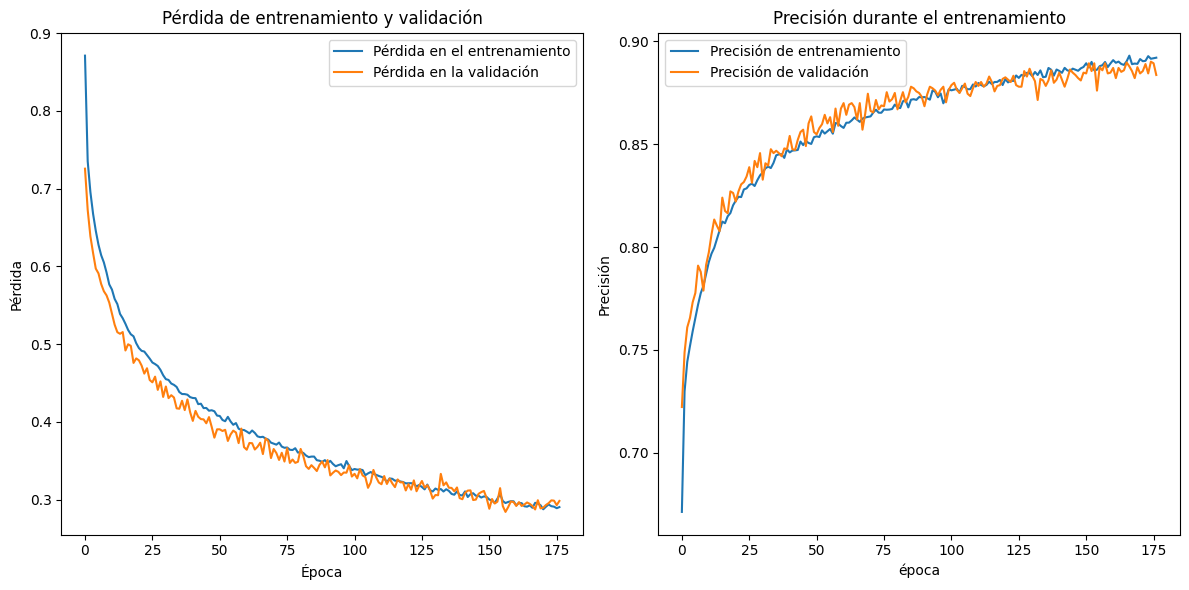

In [ ]:
# Creación de modelos separados para EDC y FDS
coefficient_dropout = 0.05
input_dim_Model1 = 10
neurons_HL1_Model1 = 128
neurons_HL2_Model1 = 64
neurons_HL3_Model1 = 32
output_dim_Model1 = 4

model_MLP = createMultiLayerPerceptronModel(input_dim_Model1 , neurons_HL1_Model1, neurons_HL2_Model1, neurons_HL3_Model1, output_dim_Model1, coefficient_dropout)
# model_MLP = createMultiLayerPerceptronModel(input_dim_Model1 , neurons_HL1_Model1, neurons_HL2_Model1, coefficient_dropout)
# Entrenamiento de ambas redes
epochs = 400
batch_size = 32

history_model = trainingModel(model_MLP, epochs, batch_size, X_train, y_train, X_val, y_val)

# Evaluación del modelo en el conjunto de prueba
loss, accuracy = model_MLP.evaluate(X_test, y_test)

print(f'Precisión del modelo EDC: {accuracy * 100:.3f}%')
print(f'Precisión del modelo FDS: {accuracy * 100:.3f}%')

# Visualización de la pérdida y precisión durante el entrenamiento
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_model.history['loss'], label='Pérdida en el entrenamiento')
plt.plot(history_model.history['val_loss'], label='Pérdida en la validación')
plt.title('Pérdida de entrenamiento y validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_model.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history_model.history['val_accuracy'], label='Precisión de validación')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('época')
plt.ylabel('Precisión')
plt.legend()

plt.tight_layout()
plt.show()


##  Inferencia del clasificador con el subconjunto de prueba (fuera de línea) y visualización de matriz de confusión.

 1. Predicción del subconjunto de prueba
  * En este sentido, se utiliza model.predict() y np.argmax() para convertir las probabilidades de salida en etiquetas predichas.

2. Métricas resultantes de proceso de inferencia fuera de línea
 * *accuracy_score*: Precisión global.
 * *confusion_matrix*: Representación detallada de verdaderos positivos como de falsos negativos por clase (gesto de muñeca) predicho por la Red Neuronal Artificial Profunda (RNAP).
 * *classification_report*: Incluye precisión, exhaustividad (recall) y F1-score por clase.

In [ ]:
# Obtener predicciones del modelo combinado
y_pred = np.argmax(model_MLP.predict(X_test), axis=1)
y_real = np.argmax(y_test, axis=1)  # Convertir etiquetas One-Hot a valores enteros

# Evaluación del modelo combinado
precision = accuracy_score(y_real, y_pred)
matriz_confusion = confusion_matrix(y_real, y_pred)
reporte_clasificacion = classification_report(y_real, y_pred, target_names=['WF', 'WE', 'HC', 'REP'])

print(f'Precisión del modelo combinado: {precision:.4f}')
print('Matriz de Confusión:')
print(matriz_confusion)
print('Reporte de Clasificación:')
print(reporte_clasificacion)


83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Precisión del modelo combinado: 0.8995
Matriz de Confusión:
[[567   2  56  34]
 [  8 623   8  20]
 [ 23  16 569  51]
 [ 28   1  18 612]]
Reporte de Clasificación:
              precision    recall  f1-score   support

          WF       0.91      0.86      0.88       659
          WE       0.97      0.95      0.96       659
          HC       0.87      0.86      0.87       659
         REP       0.85      0.93      0.89       659

    accuracy                           0.90      2636
   macro avg       0.90      0.90      0.90      2636
weighted avg       0.90      0.90      0.90      2636



## Guardar modelo preentrenado

In [ ]:
from google.colab import files

# Guardar el modelo entrenado en un archivo .h5
# model_MLP.save('modelo_MLP_withREP.h5')
# model_MLP.save('model_MLP_withREP_75Overlapping_sEMGnomFFC_LE_MatCorr+PCA_reduced4.keras')
model_MLP.save('model_MLP_withREP_50Overlapping_sEMGnomMinMaxForSubject_FFC_LE_MatCorr+PCA_reduced1.keras')
model_MLP.save('model_MLP_withREP_50Overlapping_sEMGnomMinMaxForSubject_FFC_LE_MatCorr+PCA_reduced1.h5')
# model_MLP.save('model_MLP_withREP_25percentStride.keras')
# Descargar el archivo en Colab para transferirlo al PC
# files.download('modelo_MLP_withREP.h5')
files.download('model_MLP_withREP_50Overlapping_sEMGnomMinMaxForSubject_FFC_LE_MatCorr+PCA_reduced1.keras')
files.download('model_MLP_withREP_50Overlapping_sEMGnomMinMaxForSubject_FFC_LE_MatCorr+PCA_reduced1.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Cuantización del modelo de tipo Rango Dinámico

### Cuantización del modelo de tipo Rango Dinámico: Dynamic Range Quantization
  * Por otro lado, como se comentó previamente, se decidió implementar una cuantización del modelo con el fin de reducir tiempos de inferencia pensando en la predicción en línea; bajo este respecto se definió la función: quantize_model_dynamic_range, que permite convertir el modelo en formato Keras a un modelo de tipo .tflite con cuantización de rango dinámico.
  * Este tipo cuantización está pensada en utilizarse en dispositivos con recursos limitados como microcontroladores. Empero; su uso como se detalló en la descripción de este algoritmo, es el de reducir los tiempos de inferencia para un control de la pinza robótica que reduzca tiempos de retardo o latencia para su movimiento.
  * Esta cuantización de rango dinámico se basa en el reemplazo de los pesos de coma flotante por un formato de tipo enteros de 8 bits durante la inferencia, manteniendo los datos de entrada en su formato de origen, que es float32, desembocando así en la reducción del tamaño del modelo.

In [ ]:
from google.colab import files
import tensorflow as tf
import os

def quantize_model_dynamic_range(model_h5_path):
    """
    Cuantiza un modelo H5 con Dynamic Range Quantization y guarda el modelo con sufijo '_quantDynRange'.

    Args:
        model_h5_path: Ruta al modelo original en formato H5
    """
    # Generar nombre del modelo cuantizado
    base_name = os.path.splitext(model_h5_path)[0]  # Elimina la extensión .h5
    quantized_model_path = base_name + '_quantDynRange.tflite'

    # Cargar el modelo original
    print(f"Cargando modelo original: {model_h5_path}")
    modelo = tf.keras.models.load_model(model_h5_path)

    # Convertir el modelo a TensorFlow Lite con cuantización dinámica
    print("Realizando cuantización dinámica...")
    converter = tf.lite.TFLiteConverter.from_keras_model(modelo)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]  # Dynamic Range Quantization

    # Convertir el modelo
    tflite_model = converter.convert()

    # Guardar el modelo cuantizado
    with open(quantized_model_path, 'wb') as f:
        f.write(tflite_model)

    print(f"\nModelo cuantizado guardado como: {quantized_model_path}")

    # Descargar el modelo
    files.download(quantized_model_path)

    return quantized_model_path



In [ ]:
model_path = 'model_MLP_withREP_50Overlapping_sEMGnomMinMaxForSubject_FFC_LE_MatCorr+PCA_reduced1.h5'
quantized_model_path = quantize_model_dynamic_range(model_path)

Cargando modelo original: model_MLP_withREP_50Overlapping_sEMGnomMinMaxForSubject_FFC_LE_MatCorr+PCA_reduced1.h5


Realizando cuantización dinámica...
Saved artifact at '/tmp/tmpic5gmzvx'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 10), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  138152758434064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138152758430992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138152758435024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138152758432720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138152758431952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138152758438096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138152758430224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138152758436368: TensorSpec(shape=(), dtype=tf.resource, name=None)

Modelo cuantizado guardado como: model_MLP_withREP_50Overlapping_sEMGnomMinMaxForSubject_FFC_LE_MatCorr+PCA_reduced1_quantDynRang

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Comparativa entre modelos en su variante de origen contra la cuantización de tipo Rango Dinámico

1. Carga de modelos
  * Se utiliza la función de TensorFlow *tf.keras.models.loadmodel()* para la
 importación del modelo almacenado con extensión h5.
  * Por otro lado, para el modelo de TensorFlow Lite, se emplea la función *tf.lite.Interpreter()* que permite realizar inferencia a nivel de tensor.

2. Predicción manual con TensorFlow Lite
  * En este sentido, se realiza una transforación de cada muestra para asegurar el formato correcto para el proceso de inferencia del modelo cuantizado. En particular, cada muestra se asegura de tener el formato float32, para después, asignarlo al tensor de entrada además de invocar el intérprete y se recupera el tensor de salida.

3. Análisis de métricas de ambos modelos
  * Se decide implementar una comparación de la precisión global, matriz de
 confusión normalizada y número de coincidencias de respuesta entre ambos
 modelos.

4. Visualización y comparativa entre ambos modelos
  * Se grafican tres matrices de confusión con mapas de calor para la comparativa de ambos modelos:
  * Matriz de confusión del modelo original.
  * Matriz de confusión del modelo cuantizado de tipo Rango Dinámico.
  * Diferencias entre ambas.

5. Generación de reporte de resultados y exportación del reporte
  *  Finalmente, el algoritmo genera y exporta informes en texto (.txt) y gráficos (.png) de las matrices de confusión de cada modelo para análisis a posteriori.

In [ ]:
!pip install seaborn
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from google.colab import files
import os

def compare_models_dynamic_range(model_h5_path, tflite_model_path, X_test, y_test):
    """
    Compara modelo original (H5) y cuantizado con Dynamic Range Quantization (TFLite).

    Args:
        model_h5_path: Ruta al modelo original .h5
        tflite_model_path: Ruta al modelo cuantizado .tflite
        X_test: Datos de prueba
        y_test: Etiquetas one-hot de prueba
    """
    # Configuración
    sns.set_style('darkgrid')
    class_names = ['WF', 'WE', 'HC', 'REP']
    y_true = np.argmax(y_test, axis=1)

    # 1. Cargar modelos
    print("Cargando modelos...")
    original_model = tf.keras.models.load_model(model_h5_path)

    # Cargar modelo TFLite
    interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
    interpreter.allocate_tensors()

    # Obtener detalles de entrada/salida
    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    print("\nDetalles del modelo TFLite:")
    print(f"Input - dtype: {input_details['dtype']}")
    print(f"Output - dtype: {output_details['dtype']}")

    # 2. Funciones de predicción
    def predict_original(X):
        return np.argmax(original_model.predict(X, verbose=0), axis=1)

    def predict_quantized(X):
        # Pre-allocate predictions array
        predictions = np.zeros((X.shape[0],), dtype=int)

        for i in range(X.shape[0]):
            # Prepare input data
            sample = X[i].reshape(1, -1).astype(np.float32)  # Dynamic range uses float32 input

            # Set input tensor
            interpreter.set_tensor(input_details['index'], sample)
            interpreter.invoke()

            # Get output
            output = interpreter.get_tensor(output_details['index'])
            predictions[i] = np.argmax(output)

        return predictions

    # 3. Realizar predicciones
    print("\nRealizando predicciones...")
    y_pred_original = predict_original(X_test)
    y_pred_quantized = predict_quantized(X_test)

    # 4. Calcular métricas
    print("\n=== COMPARACIÓN DETALLADA ===")
    print(f"\nPrecisión Original: {accuracy_score(y_true, y_pred_original):.4f}")
    print(f"Precisión Cuantizado: {accuracy_score(y_true, y_pred_quantized):.4f}")
    print(f"Diferencia: {abs(accuracy_score(y_true, y_pred_original) - accuracy_score(y_true, y_pred_quantized)):.4f}")

    # Calcular coincidencias
    matches = np.sum(y_pred_original == y_pred_quantized)
    print(f"\nCoincidencias entre modelos: {matches}/{len(y_true)} ({matches/len(y_true):.2%})")

    # 5. Matrices de confusión
    cm_original = confusion_matrix(y_true, y_pred_original, normalize='true')
    cm_quantized = confusion_matrix(y_true, y_pred_quantized, normalize='true')
    cm_diff = cm_original - cm_quantized  # Matriz de diferencias

    # 6. Visualización
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

    # Matriz original
    sns.heatmap(cm_original, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names, ax=ax1)
    ax1.set_title(f'Original (Acc: {accuracy_score(y_true, y_pred_original):.2%})')
    ax1.set_xlabel('Predicho')
    ax1.set_ylabel('Real')

    # Matriz cuantizado
    sns.heatmap(cm_quantized, annot=True, fmt=".2f", cmap="Greens",
                xticklabels=class_names, yticklabels=class_names, ax=ax2)
    ax2.set_title(f'Cuantizado (Acc: {accuracy_score(y_true, y_pred_quantized):.2%})')
    ax2.set_xlabel('Predicho')
    ax2.set_ylabel('Real')

    # Matriz de diferencias
    sns.heatmap(cm_diff, annot=True, fmt=".2f", cmap="coolwarm", center=0,
                xticklabels=class_names, yticklabels=class_names, ax=ax3)
    ax3.set_title('Diferencias (Original - Cuantizado)')
    ax3.set_xlabel('Predicho')
    ax3.set_ylabel('Real')

    plt.tight_layout()

    # 7. Reportes de clasificación
    print("\n=== REPORTE ORIGINAL ===")
    print(classification_report(y_true, y_pred_original, target_names=class_names, digits=4))

    print("\n=== REPORTE CUANTIZADO ===")
    print(classification_report(y_true, y_pred_quantized, target_names=class_names, digits=4))

    # 8. Guardar resultados
    results_dir = 'model_comparison_results_dynamic_range'
    os.makedirs(results_dir, exist_ok=True)

    plt.savefig(f'{results_dir}/comparison_heatmaps.png', dpi=300, bbox_inches='tight')

    with open(f'{results_dir}/comparison_report.txt', 'w') as f:
        f.write("=== DETALLES DEL MODELO TFLite ===\n")
        f.write(f"Input - dtype: {input_details['dtype']}\n")
        f.write(f"Output - dtype: {output_details['dtype']}\n\n")

        f.write("=== MÉTRICAS COMPARATIVAS ===\n")
        f.write(f"Original Accuracy: {accuracy_score(y_true, y_pred_original):.4f}\n")
        f.write(f"Quantized Accuracy: {accuracy_score(y_true, y_pred_quantized):.4f}\n")
        f.write(f"Difference: {abs(accuracy_score(y_true, y_pred_original) - accuracy_score(y_true, y_pred_quantized)):.4f}\n")
        f.write(f"Agreement: {matches}/{len(y_true)} ({matches/len(y_true):.2%})\n\n")

        f.write("=== REPORTE ORIGINAL ===\n")
        f.write(classification_report(y_true, y_pred_original, target_names=class_names, digits=4))
        f.write("\n=== REPORTE CUANTIZADO ===\n")
        f.write(classification_report(y_true, y_pred_quantized, target_names=class_names, digits=4))

    !zip -qr {results_dir}.zip {results_dir}
    files.download(f'{results_dir}.zip')
    print(f"\nResultados completos descargados como '{results_dir}.zip'")

Cargando modelos...



Detalles del modelo TFLite:
Input - dtype: <class 'numpy.float32'>
Output - dtype: <class 'numpy.float32'>

Realizando predicciones...

=== COMPARACIÓN DETALLADA ===

Precisión Original: 0.8995
Precisión Cuantizado: 0.8976
Diferencia: 0.0019

Coincidencias entre modelos: 2612/2636 (99.09%)

=== REPORTE ORIGINAL ===
              precision    recall  f1-score   support

          WF     0.9058    0.8604    0.8825       659
          WE     0.9704    0.9454    0.9577       659
          HC     0.8740    0.8634    0.8687       659
         REP     0.8536    0.9287    0.8895       659

    accuracy                         0.8995      2636
   macro avg     0.9009    0.8995    0.8996      2636
weighted avg     0.9009    0.8995    0.8996      2636


=== REPORTE CUANTIZADO ===
              precision    recall  f1-score   support

          WF     0.9111    0.8558    0.8826       659
          WE     0.9658    0.9423    0.9539       659
          HC     0.8672    0.8619    0.8645       659
  

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Resultados completos descargados como 'model_comparison_results_dynamic_range.zip'


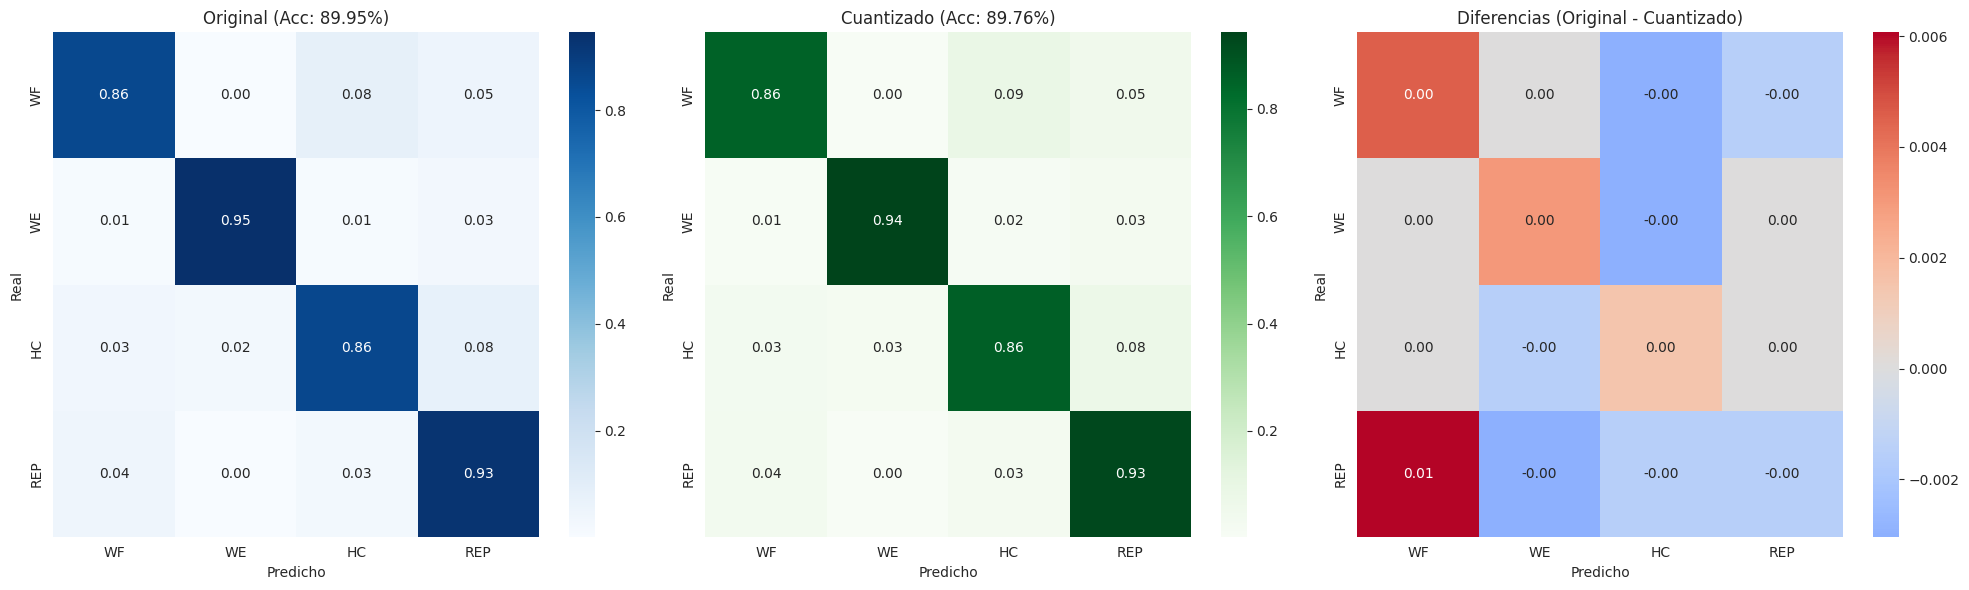

In [ ]:
compare_models_dynamic_range(model_path, quantized_model_path, X_test, y_test)